In [1]:
import sys
sys.path.insert(0,'/home/djl34/kl_git/scripts')
from notebook_imports import *

client = Client()

/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [175]:
mu = mu_list[-1]
bin_number = 9

neutral_filename = os.path.join(output_dir, f"SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__-0.0_mu_{mu}_bin_{bin_number}.npy")
neutral_sfs = np.load(neutral_filename)[None, ...]

neutral_sfs


array([[0.01519427, 0.02712086, 0.03475963, 0.07927924, 0.42849132,
        0.21125786, 0.15331399, 0.02396491, 0.02661792]])

In [151]:
output_dir = "/home/djl34/kl_git/results"
mu_list = [2e-09, 6e-09, 2e-08, 6e-08, 2e-07]

def calculate_zscore(bin_number, selection, total_length, transformation = "log", gnocchi = False):

    # bin_number = 9
    # selection = 0.1    
    # total_length = 100
    
    assert total_length % 5 == 0

    first = True
    
    for mu in mu_list:
        filename = os.path.join(output_dir, f"SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__-{selection}_mu_{mu}_bin_{bin_number}.npy")
        neutral_filename = os.path.join(output_dir, f"SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__-0.0_mu_{mu}_bin_{bin_number}.npy")
    
        sfs_array = np.load(filename)
        neutral_sfs = np.load(neutral_filename)[None, ...]
    
        length = total_length/5
        data_array = np.random.multinomial(length, sfs_array)[None, ...]
    
        if first:
            neutral_sfs_all = neutral_sfs
            data_array_all = data_array
            first = False
        else:
            neutral_sfs_all = np.concatenate((neutral_sfs_all, neutral_sfs), axis=0)
            data_array_all = np.concatenate((data_array_all, data_array), axis=0)

    if gnocchi:
        nn = np.sum(data_array_all, axis=1)
        polymorphic_prob = 1 - neutral_sfs_all[:, 0]
        p_polymorphic = einops.einsum(nn, polymorphic_prob, "N, N -> ")
        obs_polymorphic = data_array_all[:, 1:].sum()
        return calculate_gnocchi(obs_polymorphic, p_polymorphic)
    else:
        winsfs_test = mlr.WinSFS(data = data_array_all, neutral_sfs = neutral_sfs_all)
        return winsfs_test.log_likelihood_ratio_cdf(transformation = transformation, reverse = True)
        # return neutral_sfs_all, data_array_all, winsfs_test.log_likelihood_ratio_cdf(transformation = transformation, reverse = True)

def calculate_gnocchi(count, expected):
    chi_sq = (count - expected)**2/expected
    if expected > count:
        zscore = np.sqrt(chi_sq)
    else:
        zscore = -1 *np.sqrt(chi_sq)
    return zscore

def calculate_power(sample_size, z_score_cutoff, bin_number, selection, window_length, transformation = "log", gnocchi = False):
    # if bin_number = -1, use gnocchi

    list_zscore = []
    for i in range(sample_size):
        list_zscore.append(calculate_zscore(bin_number, selection, window_length, transformation, gnocchi))

    # return list_zscore
    # print(type(list_zscore))

    return sum(np.array(list_zscore) > z_score_cutoff)/sample_size, list_zscore
        

# Window Length = 100

In [166]:
selection_list = [0.0, 0.1, 0.01, 0.001]

list_of_list_power = []
list_of_list_zscore = []

window_length = 100
window_num = 500

for selection in selection_list:
    print(selection)
    
    power, list_zscore = calculate_power(window_num, 2, 9, selection, window_length = window_length, gnocchi = False)
    list_of_list_power.append([power, selection, "9 bins"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "9 bins"])

    power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, gnocchi = False)
    list_of_list_power.append([power, selection, "2 bins"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "2 bins"])

    power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, gnocchi = True)
    list_of_list_power.append([power, selection, "gnocchi"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "gnocchi"])

df = pd.DataFrame(list_of_list_power, columns=["power", "selection", "type"])
df_zscore = pd.DataFrame(list_of_list_zscore, columns=["zscore", "selection", "type"])

0.0
0.1
0.01
0.001


/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='selection', ylabel='power'>

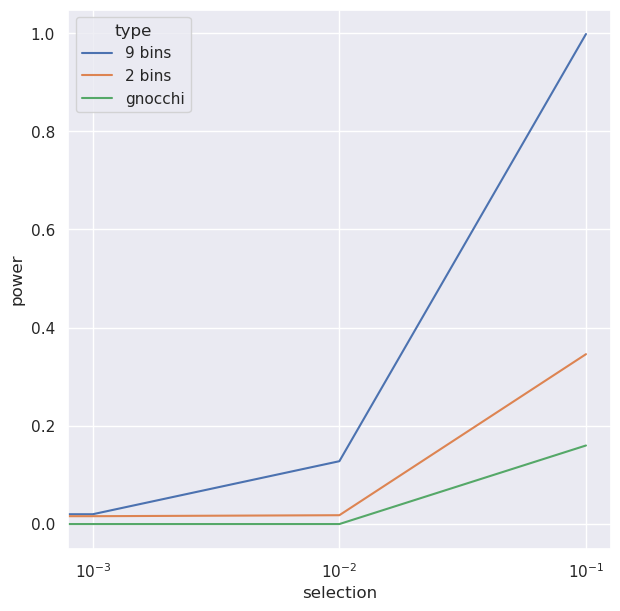

In [165]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(7, 7))

ax.set(xscale="log")

df_plot = df[df["selection"] != 0]
sns.lineplot(data=df, x="selection", y="power", hue = "type")


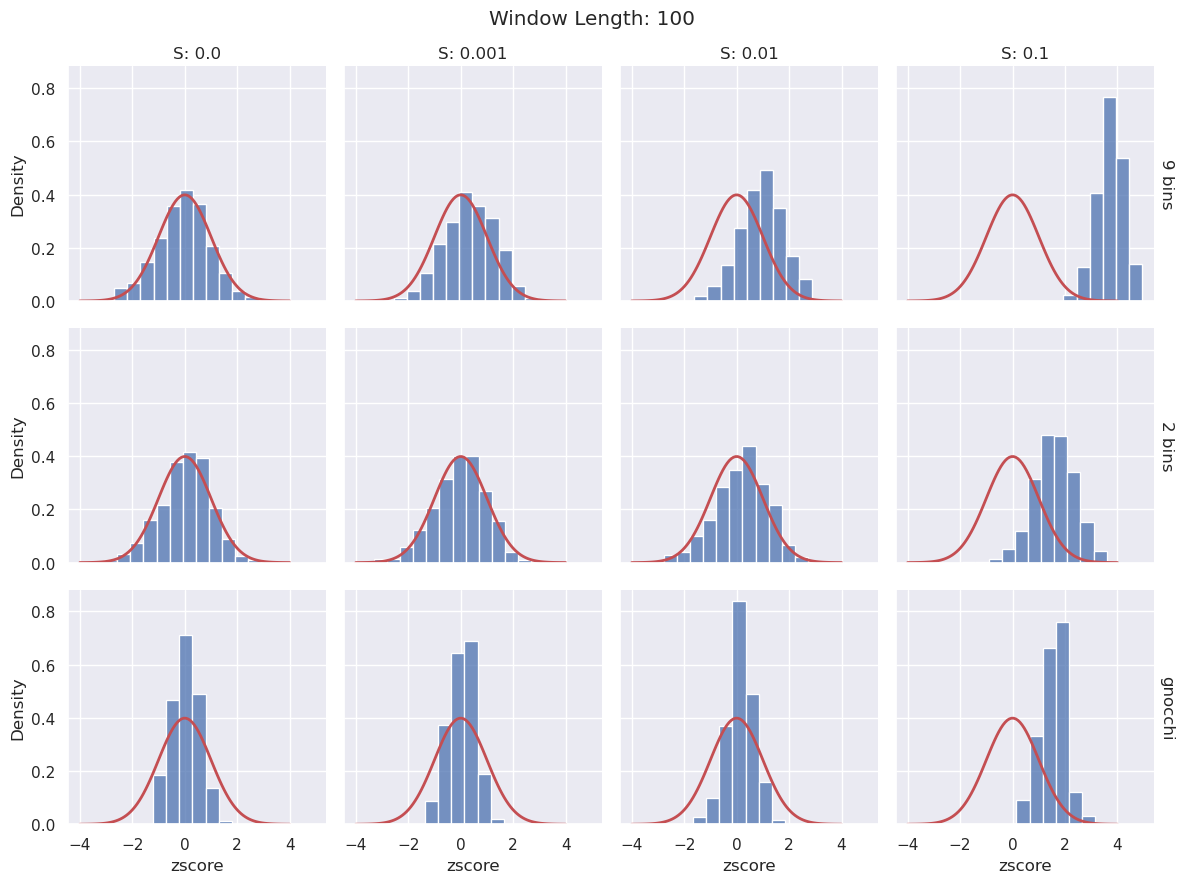

In [172]:
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(df_zscore, col="selection", row="type", height=3, margin_titles=True)

g.map(sns.histplot, "zscore", binwidth=0.5, kde=False, stat='density', label='samples')

g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

g.fig.suptitle(f'Window Length: {window_length}')

def standard_normal(*args, **kwargs):
    # x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf)

    plt.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')   

g.map(standard_normal)

# Window Length = 1000

<AxesSubplot:xlabel='selection', ylabel='power'>

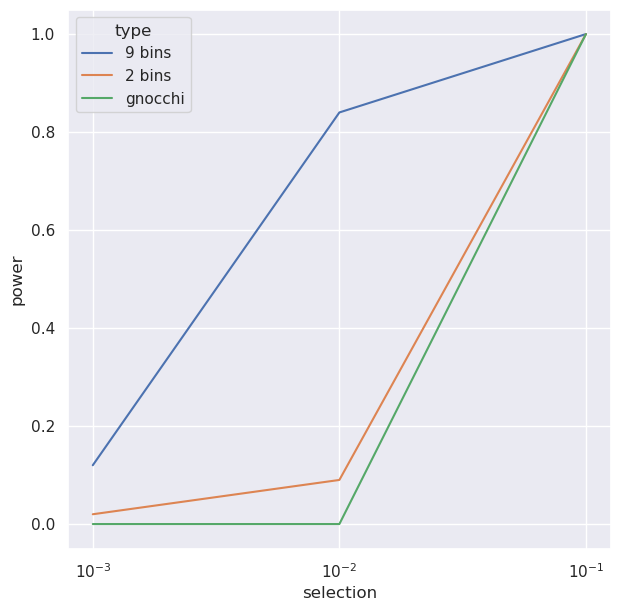

In [155]:
selection_list = [0.1, 0.01, 0.001]

list_of_list = []

window_length = 1000

for selection in selection_list:
    
    power, list_zscore = calculate_power(100, 2, 9, selection, window_length = window_length, gnocchi = False)
    list_of_list.append([power, selection, "9 bins"])

    power, list_zscore = calculate_power(100, 2, 2, selection, window_length = window_length, gnocchi = False)
    list_of_list.append([power, selection, "2 bins"])

    power, list_zscore = calculate_power(100, 2, 2, selection, window_length = window_length, gnocchi = True)
    list_of_list.append([power, selection, "gnocchi"])

df = pd.DataFrame(list_of_list, columns=["power", "selection", "type"])

sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(7, 7))

ax.set(xscale="log")

# sns.scatterplot(data=df, x="selection", y="power", hue = "type")

sns.lineplot(data=df, x="selection", y="power", hue = "type")


In [ ]:
selection = 0.01

In [ ]:
def calculate_zscore(bin_number, selection, total_length, transformation = "log", gnocchi = False):

    # bin_number = 9
    # selection = 0.1    
    # total_length = 100
    
    assert total_length % 5 == 0

    first = True
    
    for mu in mu_list:
        filename = os.path.join(output_dir, f"SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__-{selection}_mu_{mu}_bin_{bin_number}.npy")
        neutral_filename = os.path.join(output_dir, f"SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__-0.0_mu_{mu}_bin_{bin_number}.npy")
    
        sfs_array = np.load(filename)
        neutral_sfs = np.load(neutral_filename)[None, ...]
    
        length = total_length/5
        data_array = np.random.multinomial(length, sfs_array)[None, ...]
    
        if first:
            neutral_sfs_all = neutral_sfs
            data_array_all = data_array
            first = False
        else:
            neutral_sfs_all = np.concatenate((neutral_sfs_all, neutral_sfs), axis=0)
            data_array_all = np.concatenate((data_array_all, data_array), axis=0)

    if gnocchi:
        nn = np.sum(data_array_all, axis=1)
        polymorphic_prob = 1 - neutral_sfs_all[:, 0]
        p_polymorphic = einops.einsum(nn, polymorphic_prob, "N, N -> ")
        obs_polymorphic = data_array_all[:, 1:].sum()
        return calculate_gnocchi(obs_polymorphic, p_polymorphic)
    else:
        winsfs_test = mlr.WinSFS(data = data_array_all, neutral_sfs = neutral_sfs_all)
        return winsfs_test.log_likelihood_ratio_cdf(transformation = transformation, reverse = True)